In [3]:
import cv2
from PIL import Image,ImageOps,ImageEnhance
from io import BytesIO
from pokedex.augmentation import get_augment_data
from pokedex.text_detection import get_pokeid
from pokedex import SETINFO

import numpy as np
from matplotlib import pyplot as plt

import pytesseract
import pyocr

from transformers import AutoProcessor
import torch


2024-05-23 17:53:07.204884: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
from pokedex.text_detection import get_pokeid,ocr_preprocessor

In [4]:
path_name_left = '/Users/emiliasato/code/AoesJP/project_pokereader/raw_data/dict_reduceddataset_left.json'
path_name_right = '/Users/emiliasato/code/AoesJP/project_pokereader/raw_data/dict_reduceddataset_right.json'
augmented_df_left = get_augment_data(path_name_left)
augmented_df_right = get_augment_data(path_name_right)

In [19]:
img.shape

(72, 200, 1)

In [18]:
img = augmented_df_left.loc[400,'corner']
get_pokeid(img,'swsh12pt5')

'096/159'

In [15]:
augmented_df_left.loc[400,'set_id']

'swsh12pt5'

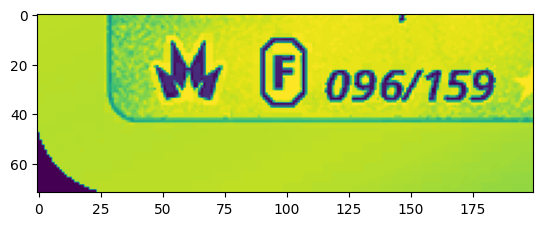

In [20]:
plt.imshow(augmented_df_left.loc[400,'corner'])

In [6]:
def preproc_clean(data: list):
    _ = np.array(data)
    return np.expand_dims(_, axis=2).astype("uint8")

def preproc_aug(data: list):
    _ = np.array(data)
    return np.squeeze(_.astype("uint8"), axis=0)

def to_rgb(img: np.ndarray):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

sm4
sm4
CPU times: user 40.6 ms, sys: 30.8 ms, total: 71.4 ms
Wall time: 424 ms


'78/1114'

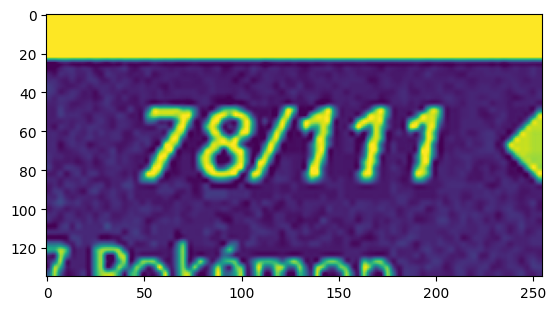

In [618]:
%%time
def ocr_preprocessor(img,set_id):
    img = preproc_clean(img).squeeze()
    img= Image.fromarray(img)
    side_offset = 10 #we need to fine tune this
    a,b,c,d = get_id_coords(set_id)

    img = img.crop((a - side_offset, b-side_offset, c+side_offset, d+ side_offset))
    img_contrast = img.resize((img.width * 3, img.height * 3), Image.BICUBIC)
    contrast_enhancer = ImageEnhance.Contrast(img_contrast)
    img_contrast = contrast_enhancer.enhance(1)
    median = np.median(img_contrast)
        
    mean = np.mean(img_contrast)
        
    im_offset = np.clip(img_contrast, 0, 255).astype("uint8")
    im_offset = Image.fromarray(im_offset)
        
    im_offset = ImageOps.invert(im_offset)
    return im_offset
    
i = 1500
img = augmented_df_left.loc[i, 'corner']
print(augmented_df_left.loc[i, 'set_id'])
set_id = augmented_df_left.loc[i, 'set_id']
print(set_id)

#plt.imshow(img)
plt.imshow(yuri_preprocess(img,set_id))
ocr_text(yuri_preprocess(img,set_id))

get_pokeid(img,'sm4')

In [619]:
get_pokeid(img,'sm4')

'78/1114'

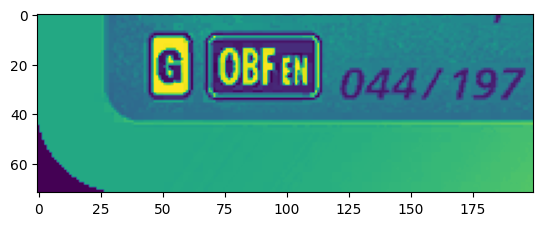

In [137]:
def ocr_text(img):
    img = preproc_clean(img).squeeze()
    tools = pyocr.get_available_tools()
    tool = tools[0]
    tool
    builder = pyocr.builders.TextBuilder(tesseract_layout=6)
    # builder.tesseract_configs.append("digits")
    builder.tesseract_configs.append("-c")
    builder.tesseract_configs.append("tessedit_char_whitelist=0123456789/")
    builder.tesseract_configs.append("--psm")
    builder.tesseract_configs.append("6")  # 0~13
    builder.tesseract_configs.append("--oem")
    builder.tesseract_configs.append("3")  # 0~3
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)
    result = tool.image_to_string(img, lang="eng", builder=builder)

    return result
img = augmented_df_left.loc[1000, 'corner']
print(ocr_text(img))
plt.imshow(img)

In [616]:
i = 1500
img = augmented_df_left.loc[i, 'corner']
get_pokeid(img,')

TypeError: get_pokeid() missing 1 required positional argument: 'set_id'

UnboundLocalError: local variable 'id_coord' referenced before assignment

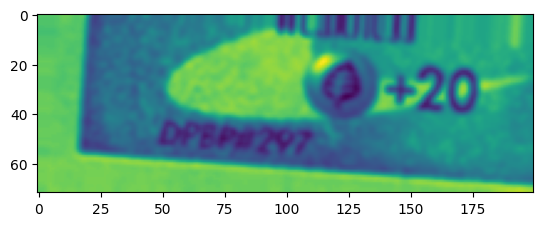

In [626]:
i = 1600
img = augmented_df_left.loc[i, 'corner']
settle = augmented_df_left.loc[i, 'set_id']
plt.imshow(img)
get_pokeid(img,settle)

In [621]:
get_pokeid(img,)

TypeError: get_pokeid() missing 1 required positional argument: 'set_id'